<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/gan/dcgan_celebrity_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# upload kaggle API key from your local machine
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shazzadraihan","key":"852204f633bb05fc928ef0439e027938"}'}

In [2]:
# make a kaggle dir, copy the API key to it
# and make sure the file is only readable by yourself (chmod 600)
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# use API command to download the dataset
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:57<00:00, 48.6MB/s]
100% 1.33G/1.33G [00:57<00:00, 24.7MB/s]


In [4]:
!unzip -qq celeba-dataset.zip

In [5]:
# import required libraries
import torch
import torchvision

import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("CUDA is available!")
else:
  print("CUDA is not available!")

device = torch.device("cuda") if train_on_gpu else torch.device("cpu")

CUDA is available!


In [7]:
# settings
    
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

random_seed = 125
set_all_seeds(random_seed)

### Load and visualiza dataset

In [9]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# load and transform data using ImageFolder
transform = transforms.Compose([
                  transforms.Resize(64),
                  transforms.CenterCrop(64),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.ImageFolder(root="./celeba", transform=transform)

num_workers = 0
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

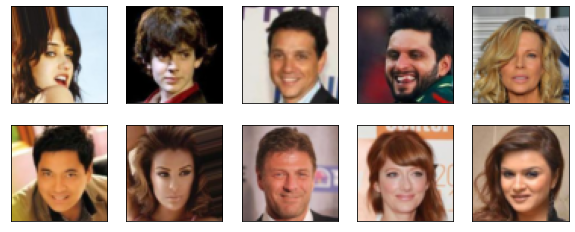

In [10]:
# visualize a batch of training data

def imshow(img):
  # unnormalize
  img = img / 2 + 0.5
  # convert from Tensor to image
  plt.imshow(np.transpose(img, (1,2,0)))

# obtain one batch on training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy() 

# display 10 images
fig = plt.figure(figsize=(10,4))
for ind in np.arange(10):
  ax = fig.add_subplot(2, 10/2, ind+1, xticks=[], yticks=[])
  imshow(images[ind])

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# Discriminator network

class Discriminator(nn.Module):
  def __init__(self, ngpu):
      super(Discriminator, self).__init__()
      self.ngpu = ngpu
      self.main = nn.Sequential(
          # input size in_channels x 64 x 64
          nn.Conv2d(in_channels, num_feat_maps_d, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (num_feat_maps_d) x 32 x 32
          nn.Conv2d(num_feat_maps_d, num_feat_maps_d * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(num_feat_maps_d * 2),
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (num_feat_maps_d*2) x 16 x 16
          nn.Conv2d(num_feat_maps_d * 2, num_feat_maps_d * 4, 4, 2, 1, bias=False),
          nn.BatchNorm2d(num_feat_maps_d * 4),
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (num_feat_maps_d*4) x 8 x 8
          nn.Conv2d(num_feat_maps_d * 4, num_feat_maps_d * 8, 4, 2, 1, bias=False),
          nn.BatchNorm2d(num_feat_maps_d * 8),
          nn.LeakyReLU(0.2, inplace=True),
          # state size. (num_feat_maps_d*8) x 4 x 4
          nn.Conv2d(num_feat_maps_d * 8, 1, 4, 1, 0, bias=False),
          nn.Sigmoid()
      )

  def forward(self, input):
      return self.main(input)

In [12]:
# Generator network

class Generator(nn.Module):
  def __init__(self, ngpu):
      super(Generator, self).__init__()
      self.ngpu = ngpu
      self.main = nn.Sequential(
          # latent vertor z, going into a convolution
          nn.ConvTranspose2d(latent_dim, num_feat_maps_g * 8, 4, 1, 0, bias=False),
          nn.BatchNorm2d(num_feat_maps_g * 8),
          nn.ReLU(True),
          # state size. (num_feat_maps_g*8) x 4 x 4
          nn.ConvTranspose2d(num_feat_maps_g * 8, num_feat_maps_g * 4, 4, 2, 1, bias=False),
          nn.BatchNorm2d(num_feat_maps_g * 4),
          nn.ReLU(True),
          # state size. (num_feat_maps_g*4) x 8 x 8
          nn.ConvTranspose2d(num_feat_maps_g * 4, num_feat_maps_g * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(num_feat_maps_g * 2),
          nn.ReLU(True),
          # state size. (num_feat_maps_g*2) x 16 x 16
          nn.ConvTranspose2d(num_feat_maps_g * 2, num_feat_maps_g, 4, 2, 1, bias=False),
          nn.BatchNorm2d(num_feat_maps_g),
          nn.ReLU(True),
          # state size. (num_feat_maps_g) x 32 x 32
          nn.ConvTranspose2d(num_feat_maps_g, in_channels, 4, 2, 1, bias=False),
          nn.Tanh()
          # state size. (in_channels) x 64 x 64
      )

  def forward(self, input):
      return self.main(input)

In [13]:
## Discriminator hyparameters

# num of channels in the training images
in_channels = 3
# size of feature map in discriminator
num_feat_maps_d = 64


## Generator hyperparameters

# size of the latent vector, z
latent_dim = 100
# size of feature map in generator
num_feat_maps_g = 64

# Number of GPUs available (0 for CPU mode)
num_gpu = 1

# Build complete network
D = Discriminator(num_gpu).to(device)
G = Generator(num_gpu).to(device)

print(D)
print()
print(G)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

Generator(
  (main): Sequenti

In [19]:
# real image loss
def real_loss(D_out, smooth=False):
  batch_size = D_out.size(0)
  if smooth:
    labels = torch.ones(batch_size) * 0.9 # label smoothing (from 1.0 to 0.9)
  else:
    labels = torch.ones(batch_size) # real label = 1
  # move labels to the right device
  labels = labels.to(device)
  # binary cross entropy with logits loss
  criterion = nn.BCEWithLogitsLoss()
  # calculate loss
  loss = criterion(D_out.squeeze(), labels)
  return loss

# fake image loss
def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size) # fake label = 0
  labels = labels.to(device)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  return loss

In [16]:
import torch.optim as optim

# Learning rate for optimizers
lr = 0.0002

# optimizer for discriminator
d_optimizer = optim.Adam(D.parameters(), lr, betas=(0.5, 0.999))
# optimizer for generator
g_optimizer = optim.Adam(G.parameters(), lr, betas=(0.5, 0.999))

In [25]:
import pickle as pkl

# number of epochs to train the model
num_epochs = 5

print_every = 400

# track training losses
G_losses, D_losses = [], []
# track generated fake samples
samples = []

# Get some fixed data / latent (noise) for sampling. These are images that are held
# constant throughout training for evaluating / visualizing the model's performance

fixed_z = torch.randn(64, latent_dim, 1, 1, device=device)

# set models to training mode
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_idx, (real_images, _) in enumerate(train_loader):

        batch_size = real_images.size(0)

        # move images to the right device        
        real_images = real_images.to(device)
        # rescale images from [0,1) to [-1, 1)
        real_images = real_images * 2 - 1 
        
        # ----------- train the discriminator ------------

        # clear the gradients of all optimized variables
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # compute the discriminator losses on real images
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # generate fake images
        with torch.no_grad():
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = G(z)
        
        # compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up losses
        d_loss = d_real_loss + d_fake_loss
        # backward pass
        d_loss.backward()
        # update parameters
        d_optimizer.step()
        
        # ----------- train the generator -------------

        # clear the gradients of all optimized variables
        g_optimizer.zero_grad()
        
        # 1. Train with fake images with flipped labels
        
        # Generate fake images
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = G(z)
        
        # compute the discriminator losses on fake images with flipped labels
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        
        # backward pass
        g_loss.backward()
        # update parameters
        g_optimizer.step()

        if batch_idx % print_every == 0:
          print('Epoch [{} / {}] | d_loss: {:.6f} | g_loss: {:.6f}'.format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    # append discriminator loss and generator loss after each epoch
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())
    
    # set to evaluation mode
    G.eval()
    # generate samples
    sample_z = G(fixed_z)
    # save generated samples
    samples.append(sample_z)
    # set back to train mode
    G.train()

# save training generator samples
with open("samples.pkl", "wb") as f:
  pkl.dump(samples, f)

Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5] | d_loss: 1.106409 | g_loss: 0.693147
Epoch [1 / 5